<table>
<tr>
    <td width=10%><img src="./img/logo_lri.jpg"></td>
    <td width=30%><img src="./img/medi-chal_logo.png" height=15%></img></td>
</tr>

</table>

<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">To be or not to be?</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">Binary Classification on Artificial Medical Data</a></center>
<br/>

---

# Group members

**Minimum 2, Maximum 3**

<span style="color:red">Write below</span>

* Last, First name
* Last, First name
* Last, First name


# Presentation of the challenge

## Main question of this challenge

* How to predict the survival of a patient according to their medical files and physiological data?
    
* Specifically, you will need to predict it during their hospital stay
 
Every day, the nursing staff collects information about the patients by asking questions and using measurement tools (stethoscope, blood test, sensors, etc.). These data are very useful for monitoring the state of health, diagnosing, and choosing treatments.

They can also be used for predictive statistical analysis.

## Data

The dataset contains information on 80,000 patients, represented by categorical, binary and, numeric variables (features). These variables are, e.g., age, sex, ethnicity, marital status, as well as medical data such as blood pressure or glucose level. There are a total of 342 variables.

The class to predict is a binary variable indicating whether the patient died or not during his stay in the hospital. Fortunately, most survive:

<!-- #%%[markdown] -->
# ![](img/tobe.png)

References and credit:

Isabelle Guyon, Kristin Bennett, Andrew Yale, Adrien Pavao, Thomas Gerspacher

## Instructions

The link to the challenge:
<https://codalab.lisn.upsaclay.fr/competitions/8802>

* **Step 1:** Register an acount at <https://codalab.lisn.upsaclay.fr>

* **Step 2:** Download the dataset from the [page](https://codalab.lisn.upsaclay.fr/competitions/328#participate-get_starting_kit) `Participate` > `Files` > `Public Data`. Place the `public_data` folder in the same folder as the one containing this notebook.

* **Step 3:** Go through this notebook. You will have to read, execute, **code your own methods** and **answer questions**. Use the ***code*** cell for coding and the ***markdown*** cell to answer questions.

## Project evaluation

* **4 points**: Exploratory analysis

* **4 points**: Clean and well-documented code

* **4 points**: Modeling (selection of the model, selection of hyperparameters)

* **4 points**: Evaluation of the performance of the model

* **4 points**: Quality of the oral presentation

### FAQ

* Submit only the notebook to eCampus (**only 1 per team**)

* The text answers (explanations, results, problems, without the code) must not exceed 1500 words

# Challenge

Prerequisite: `imblearn` (to install with `conda`)

`conda install -c conda-forge imbalanced-learn`

In [1]:
from datetime import datetime
from pathlib import Path

import imblearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import (
    decomposition,
    discriminant_analysis,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
    preprocessing,
    svm,
)

In [2]:
%reload_ext autoreload
%autoreload 2

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.4g}".format

print(sklearn.__version__)  # Version tested on sklearn.__version__ == 1.1.3

1.1.3


## 1. Understanding the problem

### Metric

Why the metric used here is the [`sklearn.metrics.balanced_accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) rather than simply [`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)?

<span style="color:red">Write your solution below</span>

Since the majority of the patient will not die, there is a high percentage of "DIDN'T DIE" cases which would result in high accuracy by simply putting "DIDN'T DIE" for every patient

## 2. Data loading

In [3]:
DATA = Path("public_data")
assert DATA.is_dir()

PRED_PATH = Path("Submissions")

DROP_FTS = ["ADMITTIME", "DISCHTIME", "SUBJECT_ID", "HADM_ID"]

In [4]:
features = pd.read_csv(
    DATA / "mimic_synthetic_feat.name", header=None
).values.flatten()

labels = pd.read_csv(
    DATA / "mimic_synthetic_label.name", header=None
).values.flatten()

x_df = pd.read_csv(
    DATA / "mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_df.drop(columns=DROP_FTS, inplace=True)

ys = pd.Series(
    pd.read_csv(
        DATA / "mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [5]:
x_df

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.21,108.7,70.84,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.33,121.1,96.92,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118.2,175.2,140.9,...,0,0,0,0,0,0,0,0,0,0
3,Medicare,ENGL,NOT_SPECIFIED,MARRIED,WHITE,M,75,83.78,89.19,86.05,...,0,0,0,0,0,0,0,0,1,0
4,Medicare,ENGL,UNOBTAINABLE,MARRIED,UNKNOWN/NOT_SPECIFIED,F,55,60.88,105.6,80.62,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79994,Medicare,ENGL,NOT_SPECIFIED,UNKNOWN_(DEFAULT),WHITE,F,76,56.04,97.86,79.71,...,0,0,0,0,0,0,0,0,1,0
79995,Medicaid,ENGL,JEWISH,MARRIED,WHITE,F,38,55.13,86.03,67.65,...,0,0,0,0,0,1,0,0,0,0
79996,Private,ENGL,NOT_SPECIFIED,SEPARATED,WHITE,F,90,74.28,91.27,91.43,...,0,0,0,0,0,0,0,0,0,0
79997,Government,ENGL,CATHOLIC,MARRIED,BLACK/AFRICAN_AMERICAN,M,57,79.26,129,98.74,...,0,0,0,0,0,0,0,0,1,0


This is **the training set**. This means that you have access to the labels and can use it however you want to prepare your model.

Later, you will have your model draw predictions from **the test set** in order to upload them to Codalab and get a score on data not seen while training the models.

In [6]:
# Load test set
x_test_df = pd.read_csv(
    DATA / "mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_test_df.drop(columns=DROP_FTS, inplace=True)

In [7]:
x_test_df

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Self_Pay,ENGL,OTHER,MARRIED,WHITE,F,18,72.64,112.7,96.46,...,0,0,0,0,0,0,0,0,0,0
1,Medicare,ENGL,NOT_SPECIFIED,SINGLE,BLACK/AFRICAN_AMERICAN,F,56,66.61,106.8,83.85,...,0,0,0,0,0,0,0,0,1,0
2,Medicaid,ENGL,CATHOLIC,SINGLE,WHITE,M,32,69.72,102.7,87.26,...,0,0,0,0,0,0,0,0,0,0
3,Private,ENGL,OTHER,MARRIED,WHITE,M,80,63.28,85.75,76.75,...,0,0,0,0,0,0,0,0,0,0
4,Medicare,ENGL,JEWISH,WIDOWED,WHITE,M,83,75.23,104.4,94.18,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19996,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,M,85,51.54,72.39,69.96,...,0,0,0,0,0,0,0,0,1,0
19997,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,M,69,61.79,75.33,80.25,...,0,0,0,0,0,1,0,0,1,0
19998,Medicare,ENGL,CHRISTIAN_SCIENTIST,MARRIED,UNKNOWN/NOT_SPECIFIED,M,84,94.34,132.7,115.4,...,0,0,0,0,0,0,0,0,0,0
19999,Private,ENGL,PROTESTANT_QUAKER,MARRIED,BLACK/AFRICAN_AMERICAN,M,84,48.68,85.93,57.75,...,0,0,0,0,0,0,1,0,0,0


## 3. Exploratory analysis

#### Features' types

In [8]:
types = pd.read_csv(DATA / "mimic_synthetic_feat.type", header=None).set_index(
    features
)[0]

types.value_counts()

Numerical      226
Binary         107
Categorical      8
Name: 0, dtype: int64

#### Target feature distribution

In [9]:
ys.describe()

count     8e+04
mean    0.03496
std      0.1837
min           0
25%           0
50%           0
75%           0
max           1
dtype: float64

### Code: Produce the following graphs

* Bar chart to show the target feature distribution

* Bar charts of 4 categorical variables (e.g., "LANGUAGE", "MARITAL_STATUS")

* Show the correlation between a selection of features and the target feature y

* Another graph or any exploratory analysis you can think of

<span style="color:red">Implement your solution below</span>

<span style="color:red">
    Use markdown cells to add comments
</span>

<AxesSubplot: ylabel='count'>

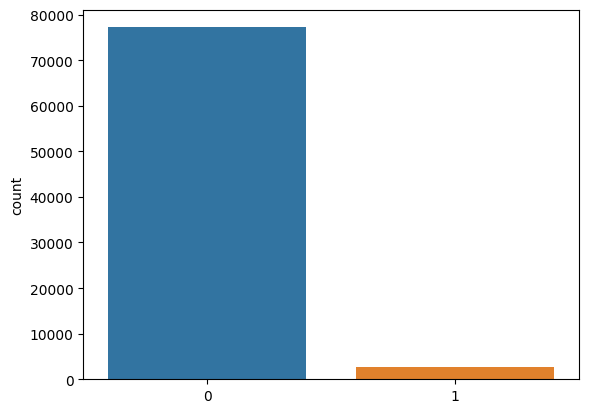

In [10]:
# target feature distribution
sns.countplot(x=ys)

<AxesSubplot: xlabel='ICU', ylabel='count'>

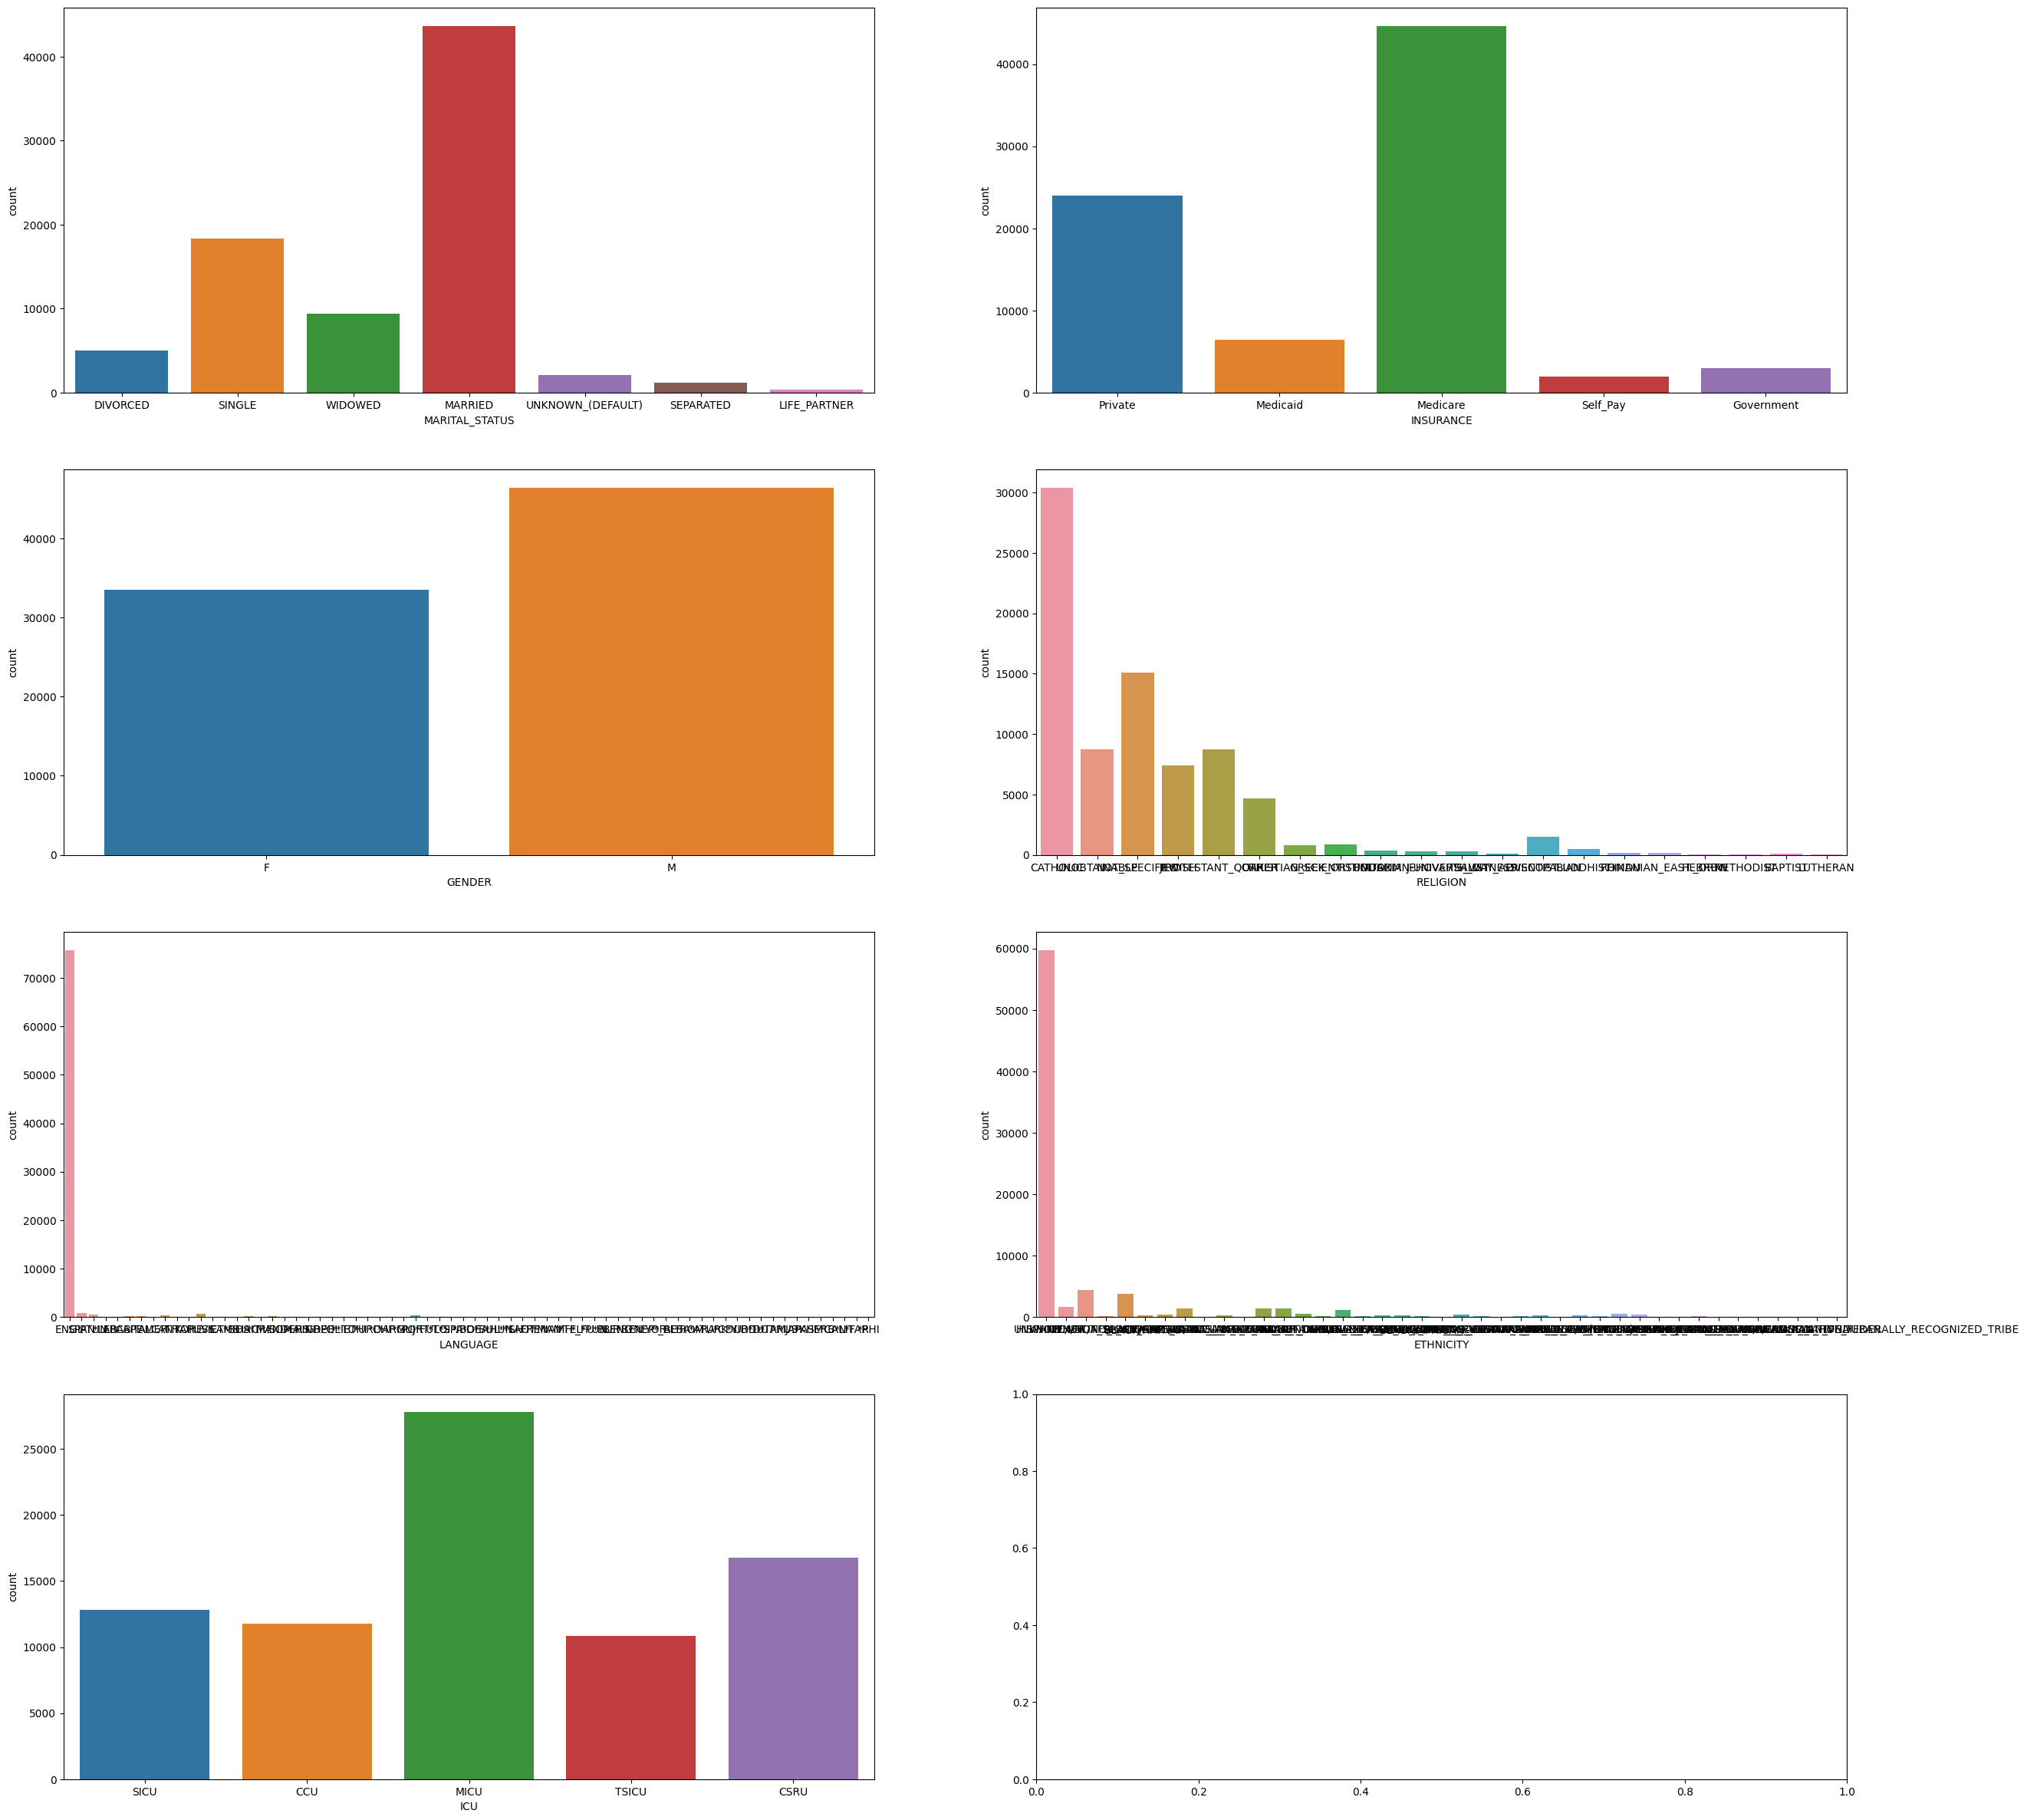

In [13]:
# bar charts of categorical features
fig, axes = plt.subplots(4,2, figsize=(30,30))
sns.countplot(ax=axes[0,0],x=x_df["MARITAL_STATUS"])
sns.countplot(ax=axes[0,1],x=x_df["INSURANCE"])
sns.countplot(ax=axes[1,0],x=x_df["GENDER"])
sns.countplot(ax=axes[1,1],x=x_df["RELIGION"])
sns.countplot(ax=axes[2,0],x=x_df["LANGUAGE"])
sns.countplot(ax=axes[2,1],x=x_df["ETHNICITY"])
sns.countplot(ax=axes[3,0],x=x_df["ICU"])

<AxesSubplot: xlabel='ICU', ylabel='count'>

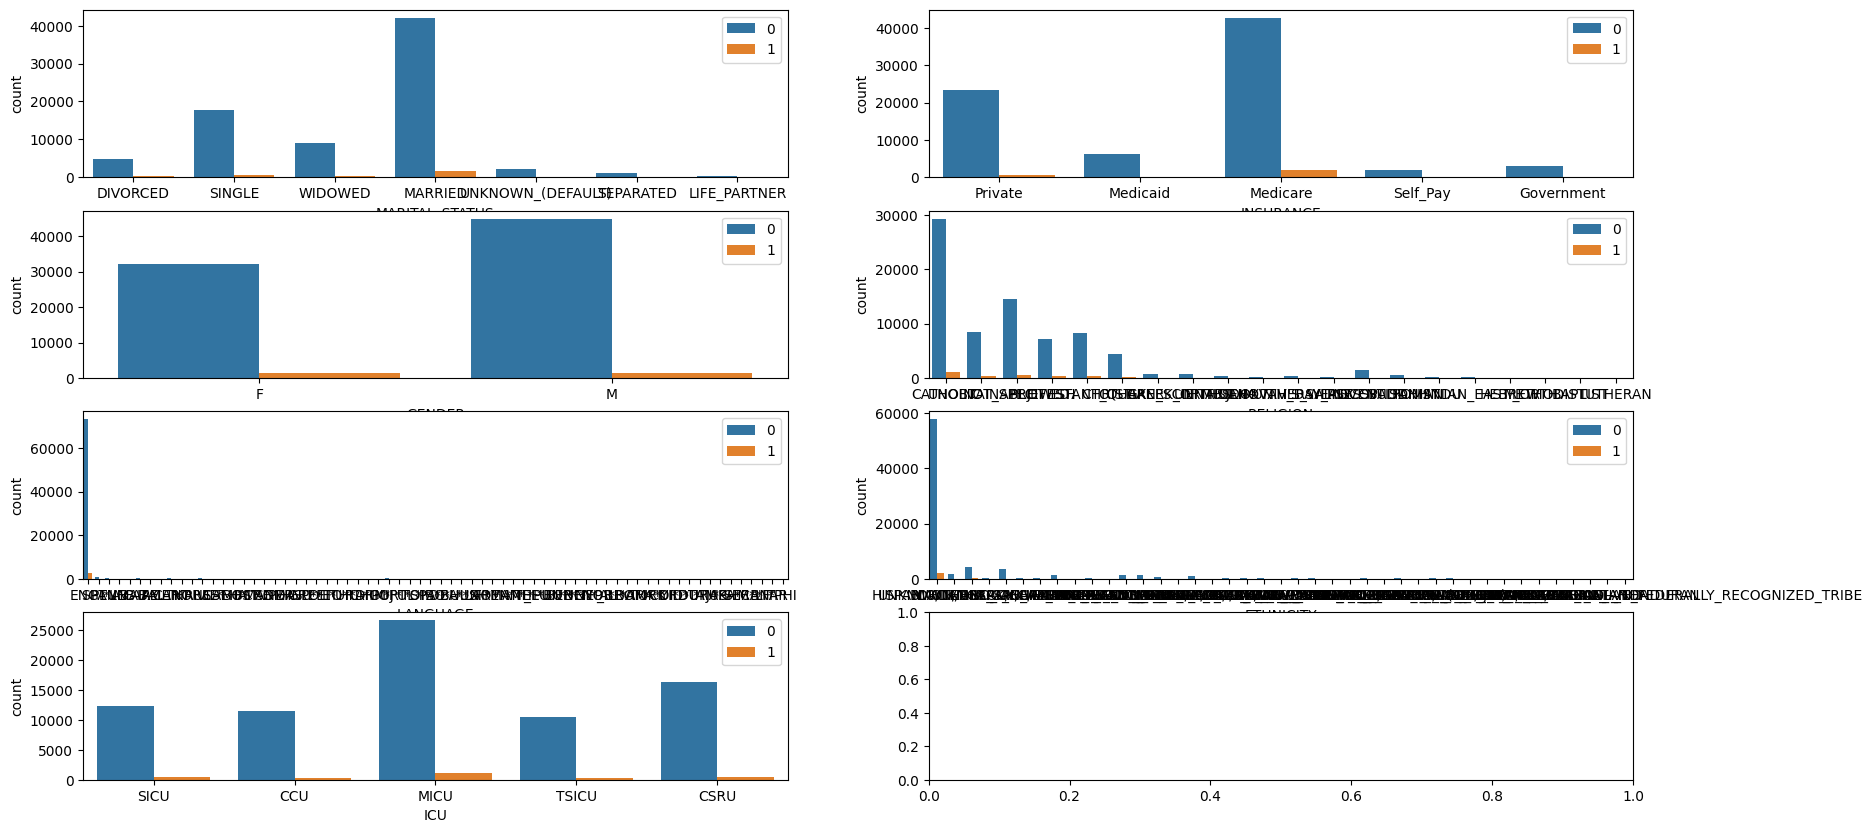

In [14]:
# correlation with the target feature
fig, axes = plt.subplots(4,2, figsize=(20,10))
sns.countplot(ax=axes[0,0],x=x_df["MARITAL_STATUS"],hue=ys)
sns.countplot(ax=axes[0,1],x=x_df["INSURANCE"],hue=ys)
sns.countplot(ax=axes[1,0],x=x_df["GENDER"],hue=ys)
sns.countplot(ax=axes[1,1],x=x_df["RELIGION"],hue=ys)
sns.countplot(ax=axes[2,0],x=x_df["LANGUAGE"],hue=ys)
sns.countplot(ax=axes[2,1],x=x_df["ETHNICITY"],hue=ys)
sns.countplot(ax=axes[3,0],x=x_df["ICU"],hue=ys)

## 4. Preprocessing

### Code: Missing values handling

The simplest solution is to eliminate all the columns where there is missing data, but a large part of the information may be lost.

If a small number of instances is concerned, it is more pertinent to delete the rows (instances) rather than the entire columns (variables). But you need to **pay attention**, if you **cannot** change the number of rows in the **test set**, or the competition grader will **fail**.

A third solution would be to replace undefined values with the most probable value of the variable. As these missing values relate exclusively to categorical and binary variables, the most probable value is the [*mode*](https://en.wikipedia.org/wiki/Mode_(statistics)).

A first baseline version is given, but it should be improved. It discards all categorical features and instances with NAN.

In [11]:
print(x_df.shape, x_test_df.shape)

x_baseline_df = x_df.select_dtypes([np.number]).copy()
x_baseline_test_df = x_test_df.select_dtypes([np.number]).copy()

x_baseline_df.fillna(0, inplace=True)
x_baseline_test_df.fillna(0, inplace=True)

print(x_baseline_df.shape, x_baseline_test_df.shape)

(79999, 337) (20001, 337)
(79999, 330) (20001, 330)


#### Exploration

First check the number of missing data per features and per instances (patient). Don't forget to process both the training and the test sets!

<span style="color:red">Implement your solution below</span>

In [12]:
# number of missing data
# we took head(10) to make sure to see all the features with >0 NaN 
x_df.isnull().sum().sort_values(ascending=False).head(10)

ECodes:Adverseeffectsofmedicalcare    6
Otnutritdx                            2
ICU                                   2
LANGUAGE                              1
MARITAL_STATUS                        1
Othnervdx                             1
INSURANCE                             0
Uteruscancr                           0
Otaftercare                           0
Exam/eval                             0
dtype: int64

In [13]:
x_test_df.isnull().sum().sort_values(ascending=False)

ECodes:Adverseeffectsofmedicalcare    3
LANGUAGE                              2
Shock                                 0
Otaftercare                           0
Exam/eval                             0
                                     ..
Peritonitis                           0
Anal/rectal                           0
Diverticulos                          0
Intobstruct                           0
Htncomplicn                           0
Length: 337, dtype: int64

In [14]:
# checking that they all belong to categorical or binary variables
x_df["ECodes:Adverseeffectsofmedicalcare"].describe()

count   7.999e+04
mean       0.1192
std         0.324
min             0
25%             0
50%             0
75%             0
max             1
Name: ECodes:Adverseeffectsofmedicalcare, dtype: float64

In [17]:
x_df["LANGUAGE"].describe()

count     79998
unique       68
top        ENGL
freq      75733
Name: LANGUAGE, dtype: object

In [18]:
x_df["Otnutritdx"].describe()

count    8e+04
mean    0.0607
std     0.2388
min          0
25%          0
50%          0
75%          0
max          1
Name: Otnutritdx, dtype: float64

In [19]:
x_df["ICU"].describe()

count     79997
unique        5
top        MICU
freq      27780
Name: ICU, dtype: object

In [20]:
x_df["Othnervdx"].describe()

count    8e+04
mean    0.1455
std     0.3526
min          0
25%          0
50%          0
75%          0
max          1
Name: Othnervdx, dtype: float64

In [21]:
x_df["MARITAL_STATUS"].describe()

count       79998
unique          7
top       MARRIED
freq        43661
Name: MARITAL_STATUS, dtype: object

<AxesSubplot: >

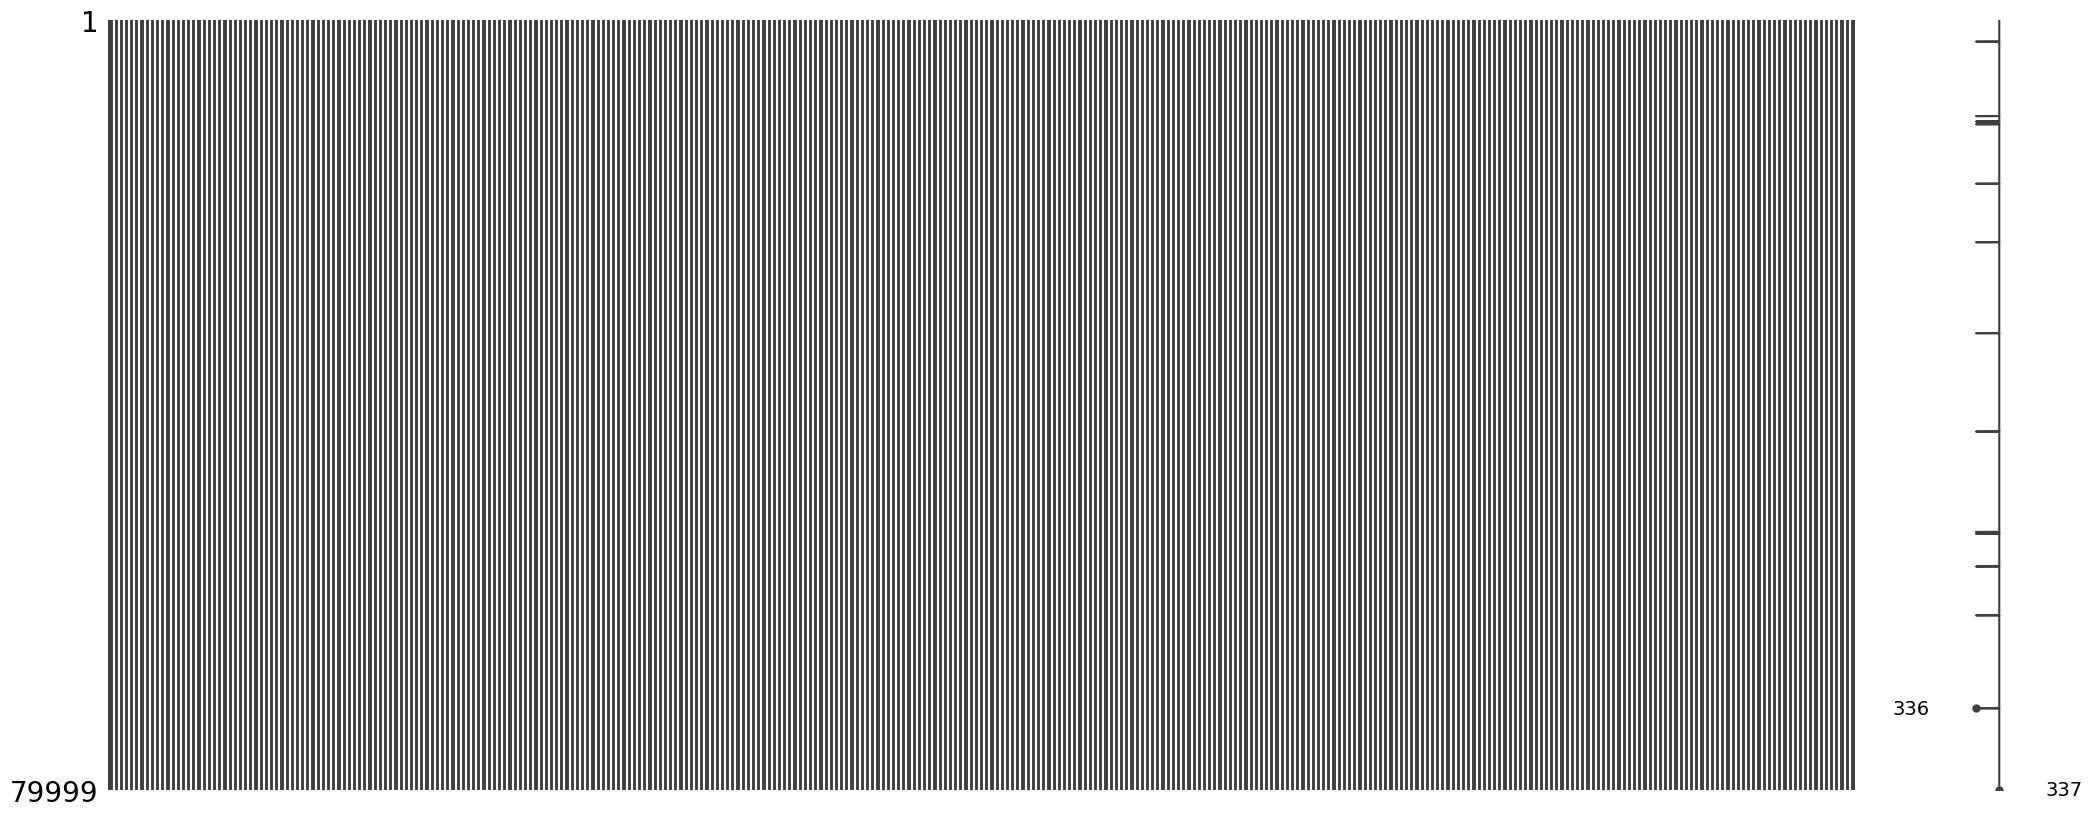

In [22]:
# check the missing data per instances
import missingno as msno
# 336 features minimum means only 1 missing feature max per instances
msno.matrix(x_df)

<AxesSubplot: >

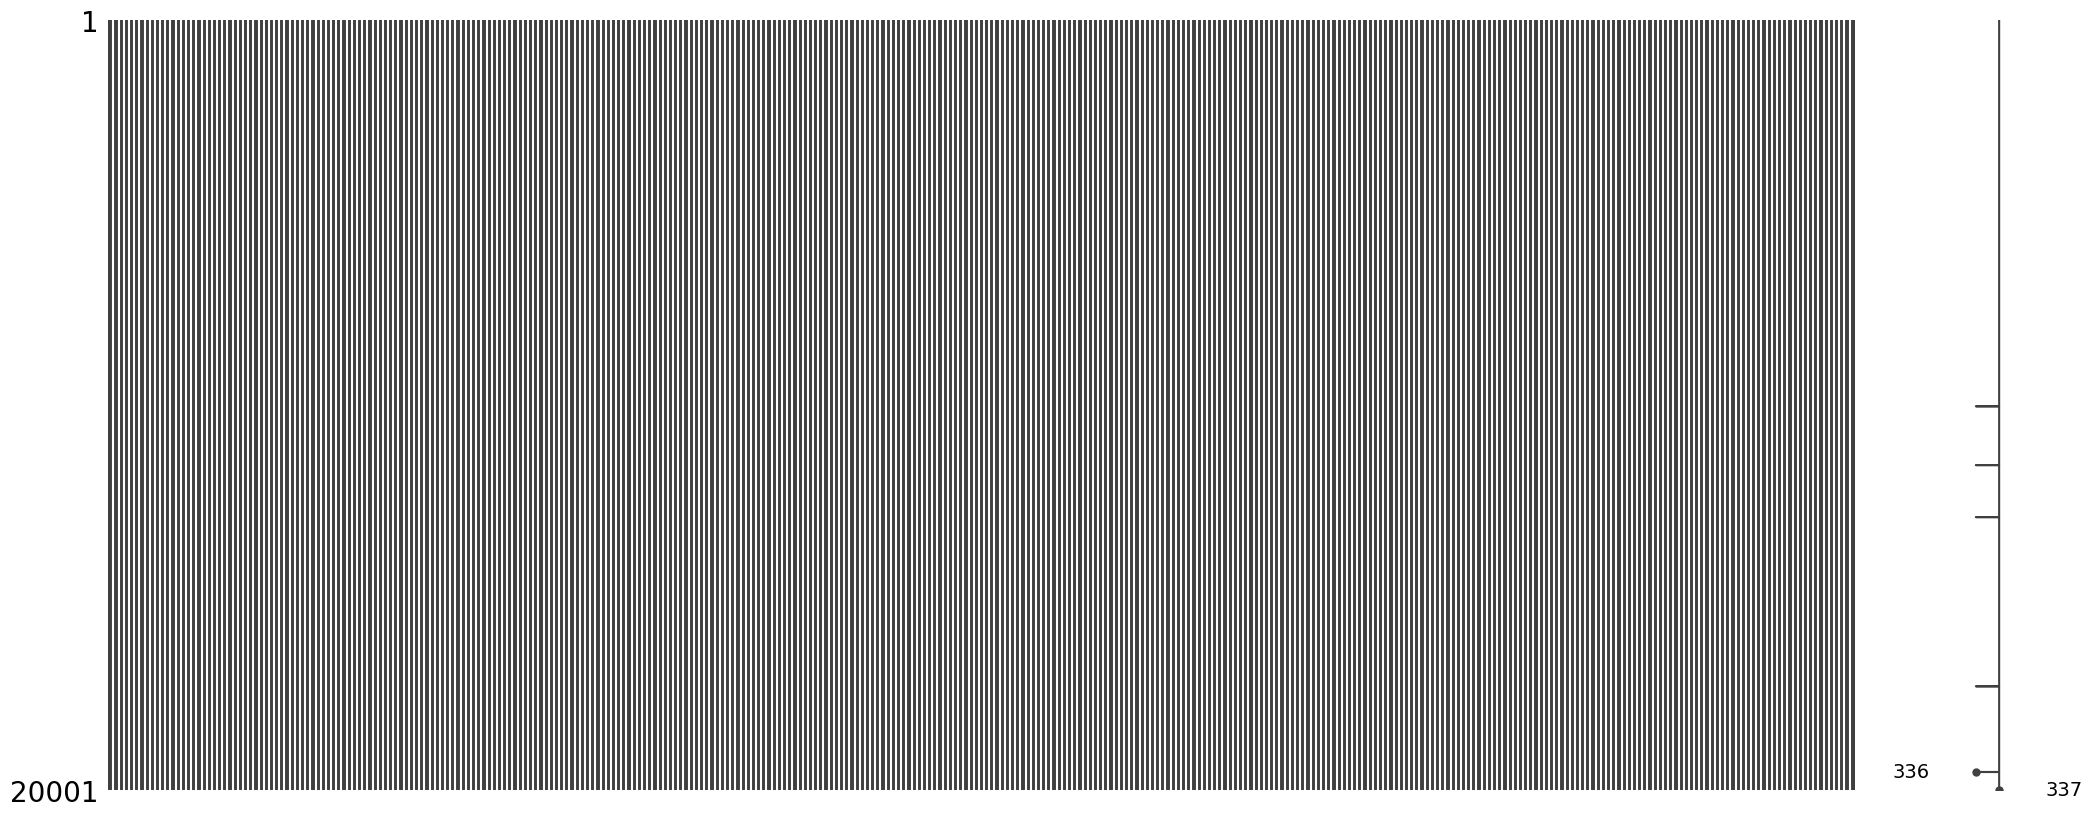

In [23]:
msno.matrix(x_test_df)

#### Fixing

Now you can apply your chosen strategy

<span style="color:red">Implement your solution below</span>

In [15]:
# filling with the most probable value (mode)
x_df["ECodes:Adverseeffectsofmedicalcare"].fillna(x_df["ECodes:Adverseeffectsofmedicalcare"].mode()[0],inplace=True)
x_df["LANGUAGE"].fillna(x_df["LANGUAGE"].mode()[0],inplace=True)
x_df["Otnutritdx"].fillna(x_df["Otnutritdx"].mode()[0],inplace=True)
x_df["ICU"].fillna(x_df["ICU"].mode()[0],inplace=True)
x_df["Othnervdx"].fillna(x_df["Othnervdx"].mode()[0],inplace=True)
x_df["MARITAL_STATUS"].fillna(x_df["MARITAL_STATUS"].mode()[0],inplace=True)


x_test_df["ECodes:Adverseeffectsofmedicalcare"].fillna(x_test_df["ECodes:Adverseeffectsofmedicalcare"].mode()[0],inplace=True)
x_test_df["LANGUAGE"].fillna(x_test_df["LANGUAGE"].mode()[0],inplace=True)


In [16]:
# checking that we do not have missing values anymore
x_df.isnull().sum().sort_values(ascending=False)

INSURANCE       0
Nausea/vomit    0
Unclassified    0
Otherscreen     0
Otaftercare     0
               ..
Biliarydx       0
Peritonitis     0
Anal/rectal     0
Diverticulos    0
Htncomplicn     0
Length: 337, dtype: int64

In [17]:
x_test_df.isnull().sum().sort_values(ascending=False)

INSURANCE       0
Nausea/vomit    0
Unclassified    0
Otherscreen     0
Otaftercare     0
               ..
Biliarydx       0
Peritonitis     0
Anal/rectal     0
Diverticulos    0
Htncomplicn     0
Length: 337, dtype: int64

### Reduce data scarcity (not enough data per class)

For example, you could simplify data by grouping rare categories.

<span style="color:red">Implement your solution below</span>

In [21]:
x_df.select_dtypes(object)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,ICU
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,SICU
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,CCU
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,MICU
3,Medicare,ENGL,NOT_SPECIFIED,MARRIED,WHITE,M,CCU
4,Medicare,ENGL,UNOBTAINABLE,MARRIED,UNKNOWN/NOT_SPECIFIED,F,MICU
...,...,...,...,...,...,...,...
79994,Medicare,ENGL,NOT_SPECIFIED,UNKNOWN_(DEFAULT),WHITE,F,CSRU
79995,Medicaid,ENGL,JEWISH,MARRIED,WHITE,F,TSICU
79996,Private,ENGL,NOT_SPECIFIED,SEPARATED,WHITE,F,SICU
79997,Government,ENGL,CATHOLIC,MARRIED,BLACK/AFRICAN_AMERICAN,M,TSICU


In [18]:
import feature_engine.encoding as ecd
encoder = ecd.RareLabelEncoder(tol=0.05, n_categories=3,
                               variables=["INSURANCE","LANGUAGE","RELIGION","MARITAL_STATUS","ETHNICITY","GENDER","ICU"],
                               replace_with="Rare")


x_df = encoder.fit_transform(x_df)
x_test_df = encoder.transform(x_test_df)

/home/maxime/Scientific_Programming/testvenv/lib/python3.8/site-packages/feature_engine/encoding/rare_label.py:199: UserWarning: The number of unique categories for variable GENDER is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(


<AxesSubplot: xlabel='ICU', ylabel='count'>

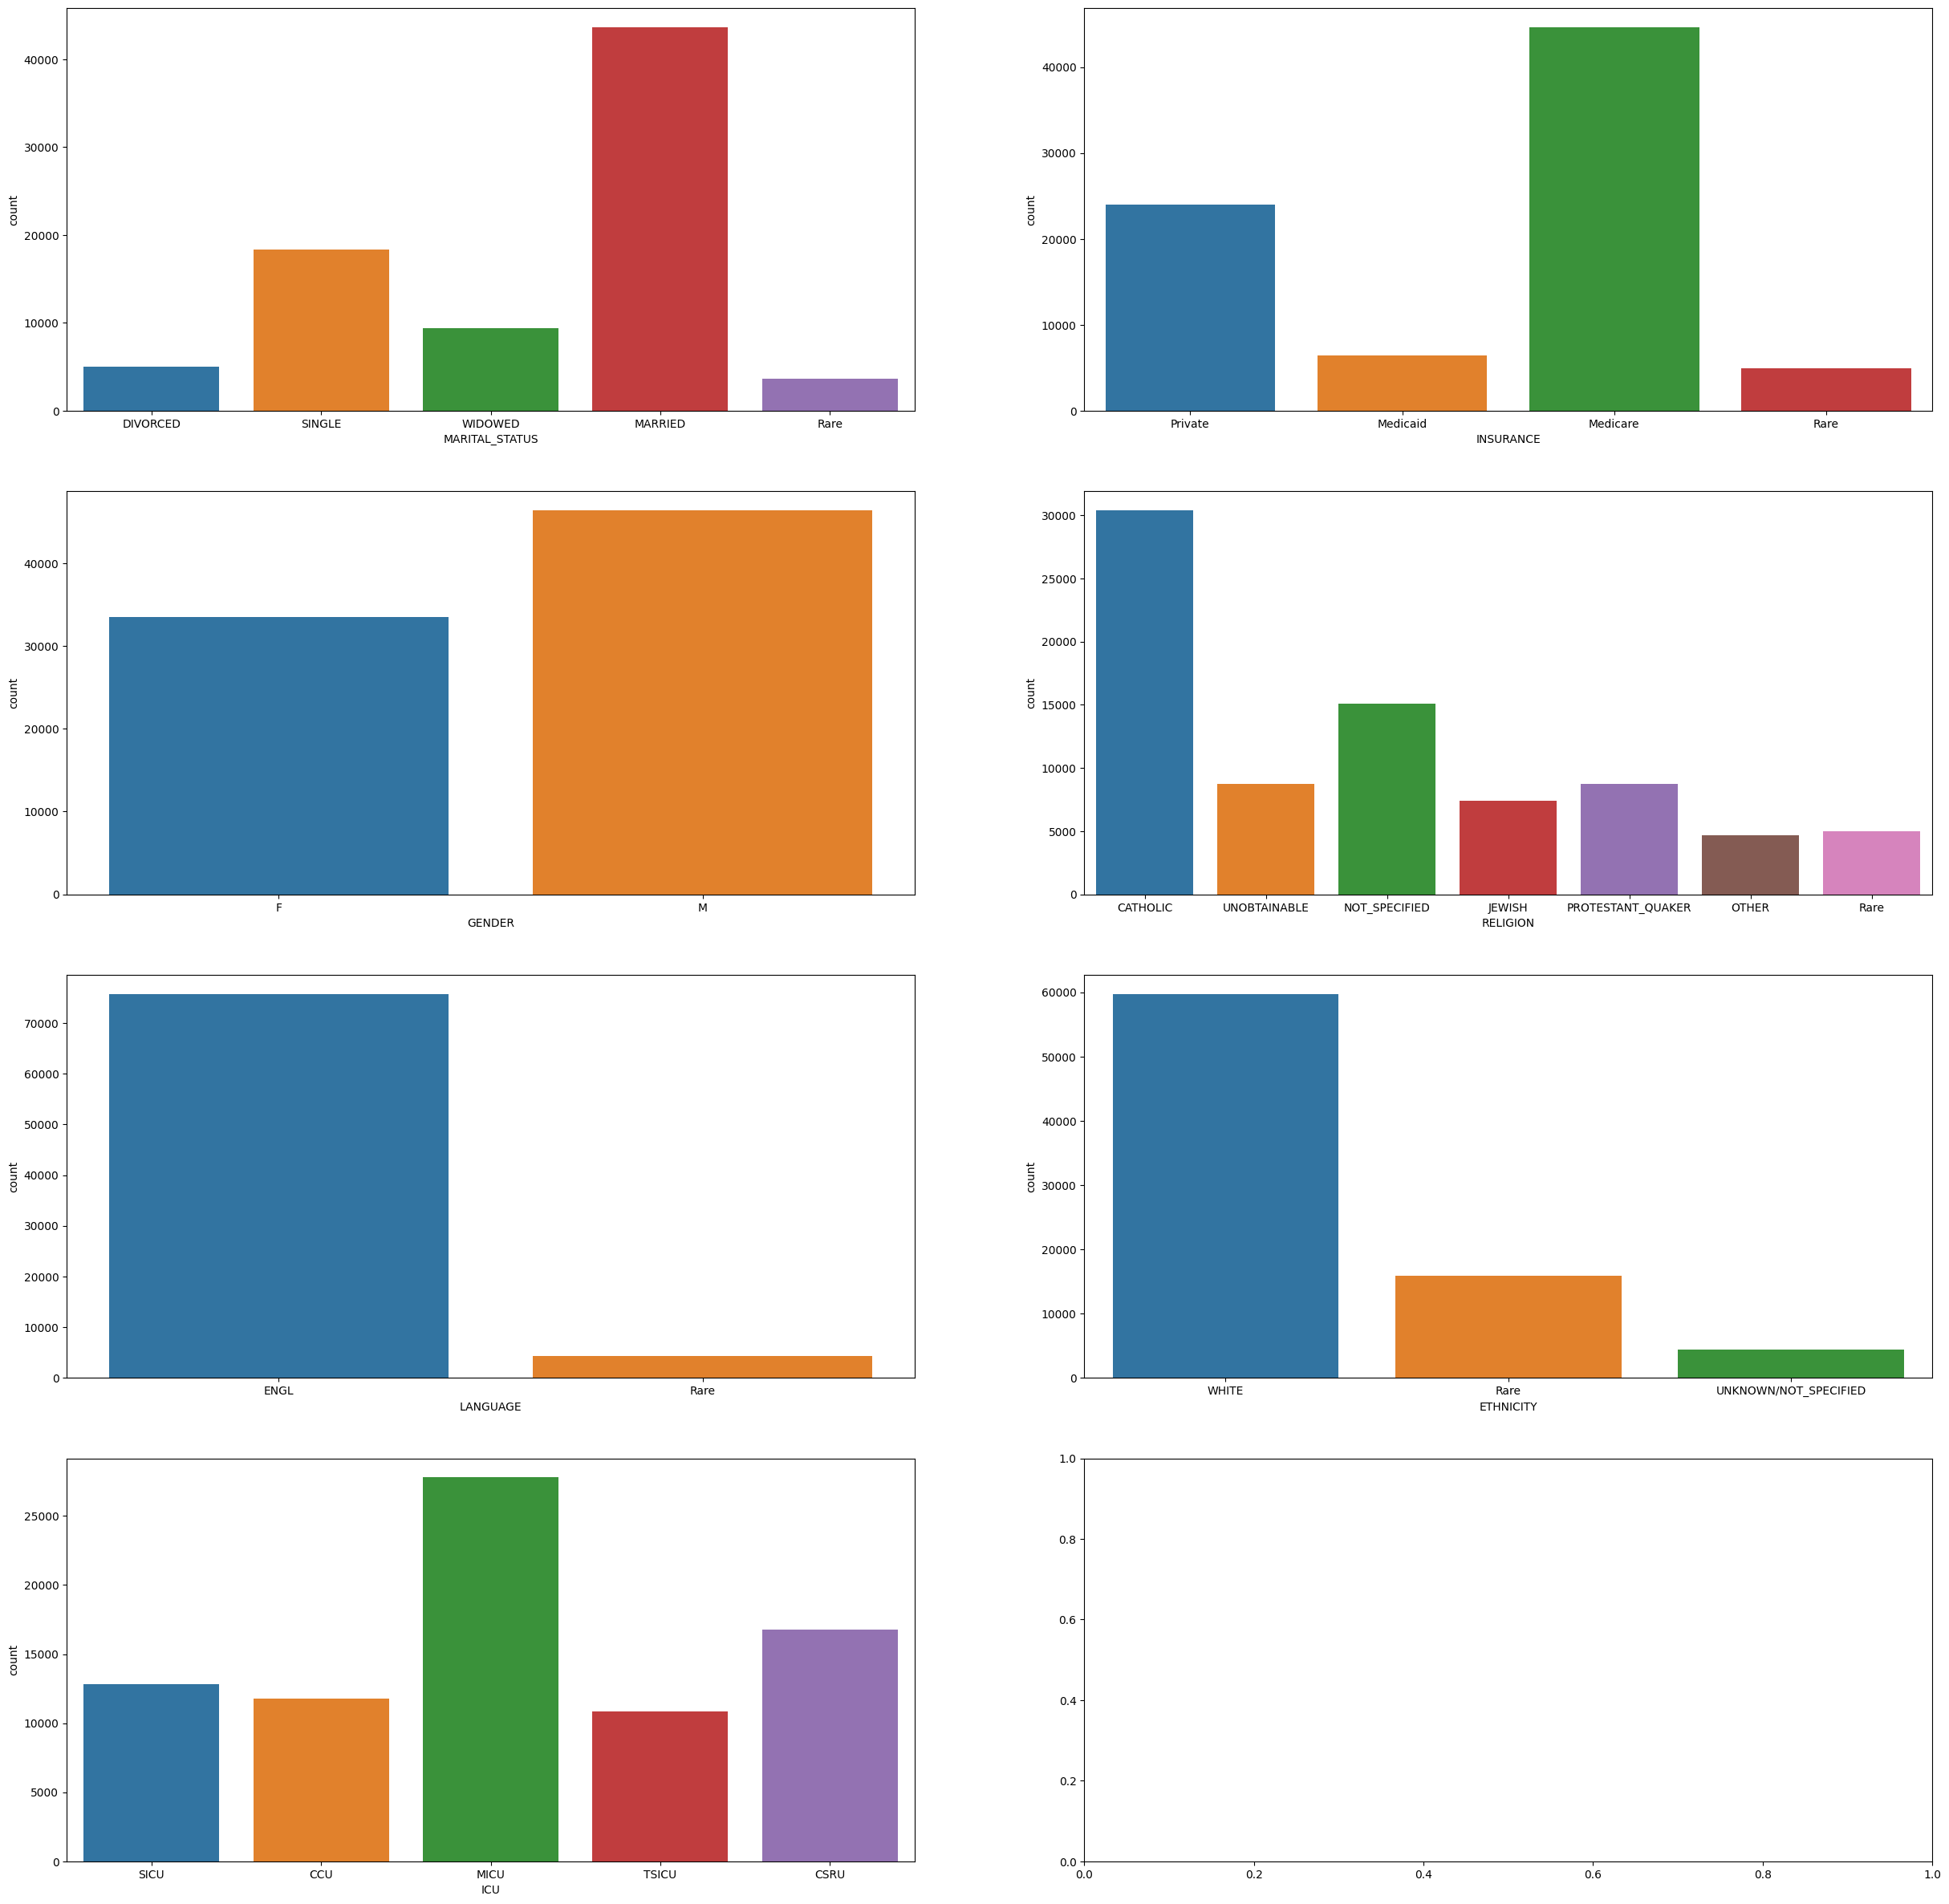

In [23]:
# bar charts of categorical features after reducing the scarcity
fig, axes = plt.subplots(4,2, figsize=(30,30))
sns.countplot(ax=axes[0,0],x=x_df["MARITAL_STATUS"])
sns.countplot(ax=axes[0,1],x=x_df["INSURANCE"])
sns.countplot(ax=axes[1,0],x=x_df["GENDER"])
sns.countplot(ax=axes[1,1],x=x_df["RELIGION"])
sns.countplot(ax=axes[2,0],x=x_df["LANGUAGE"])
sns.countplot(ax=axes[2,1],x=x_df["ETHNICITY"])
sns.countplot(ax=axes[3,0],x=x_df["ICU"])

<AxesSubplot: xlabel='ICU', ylabel='count'>

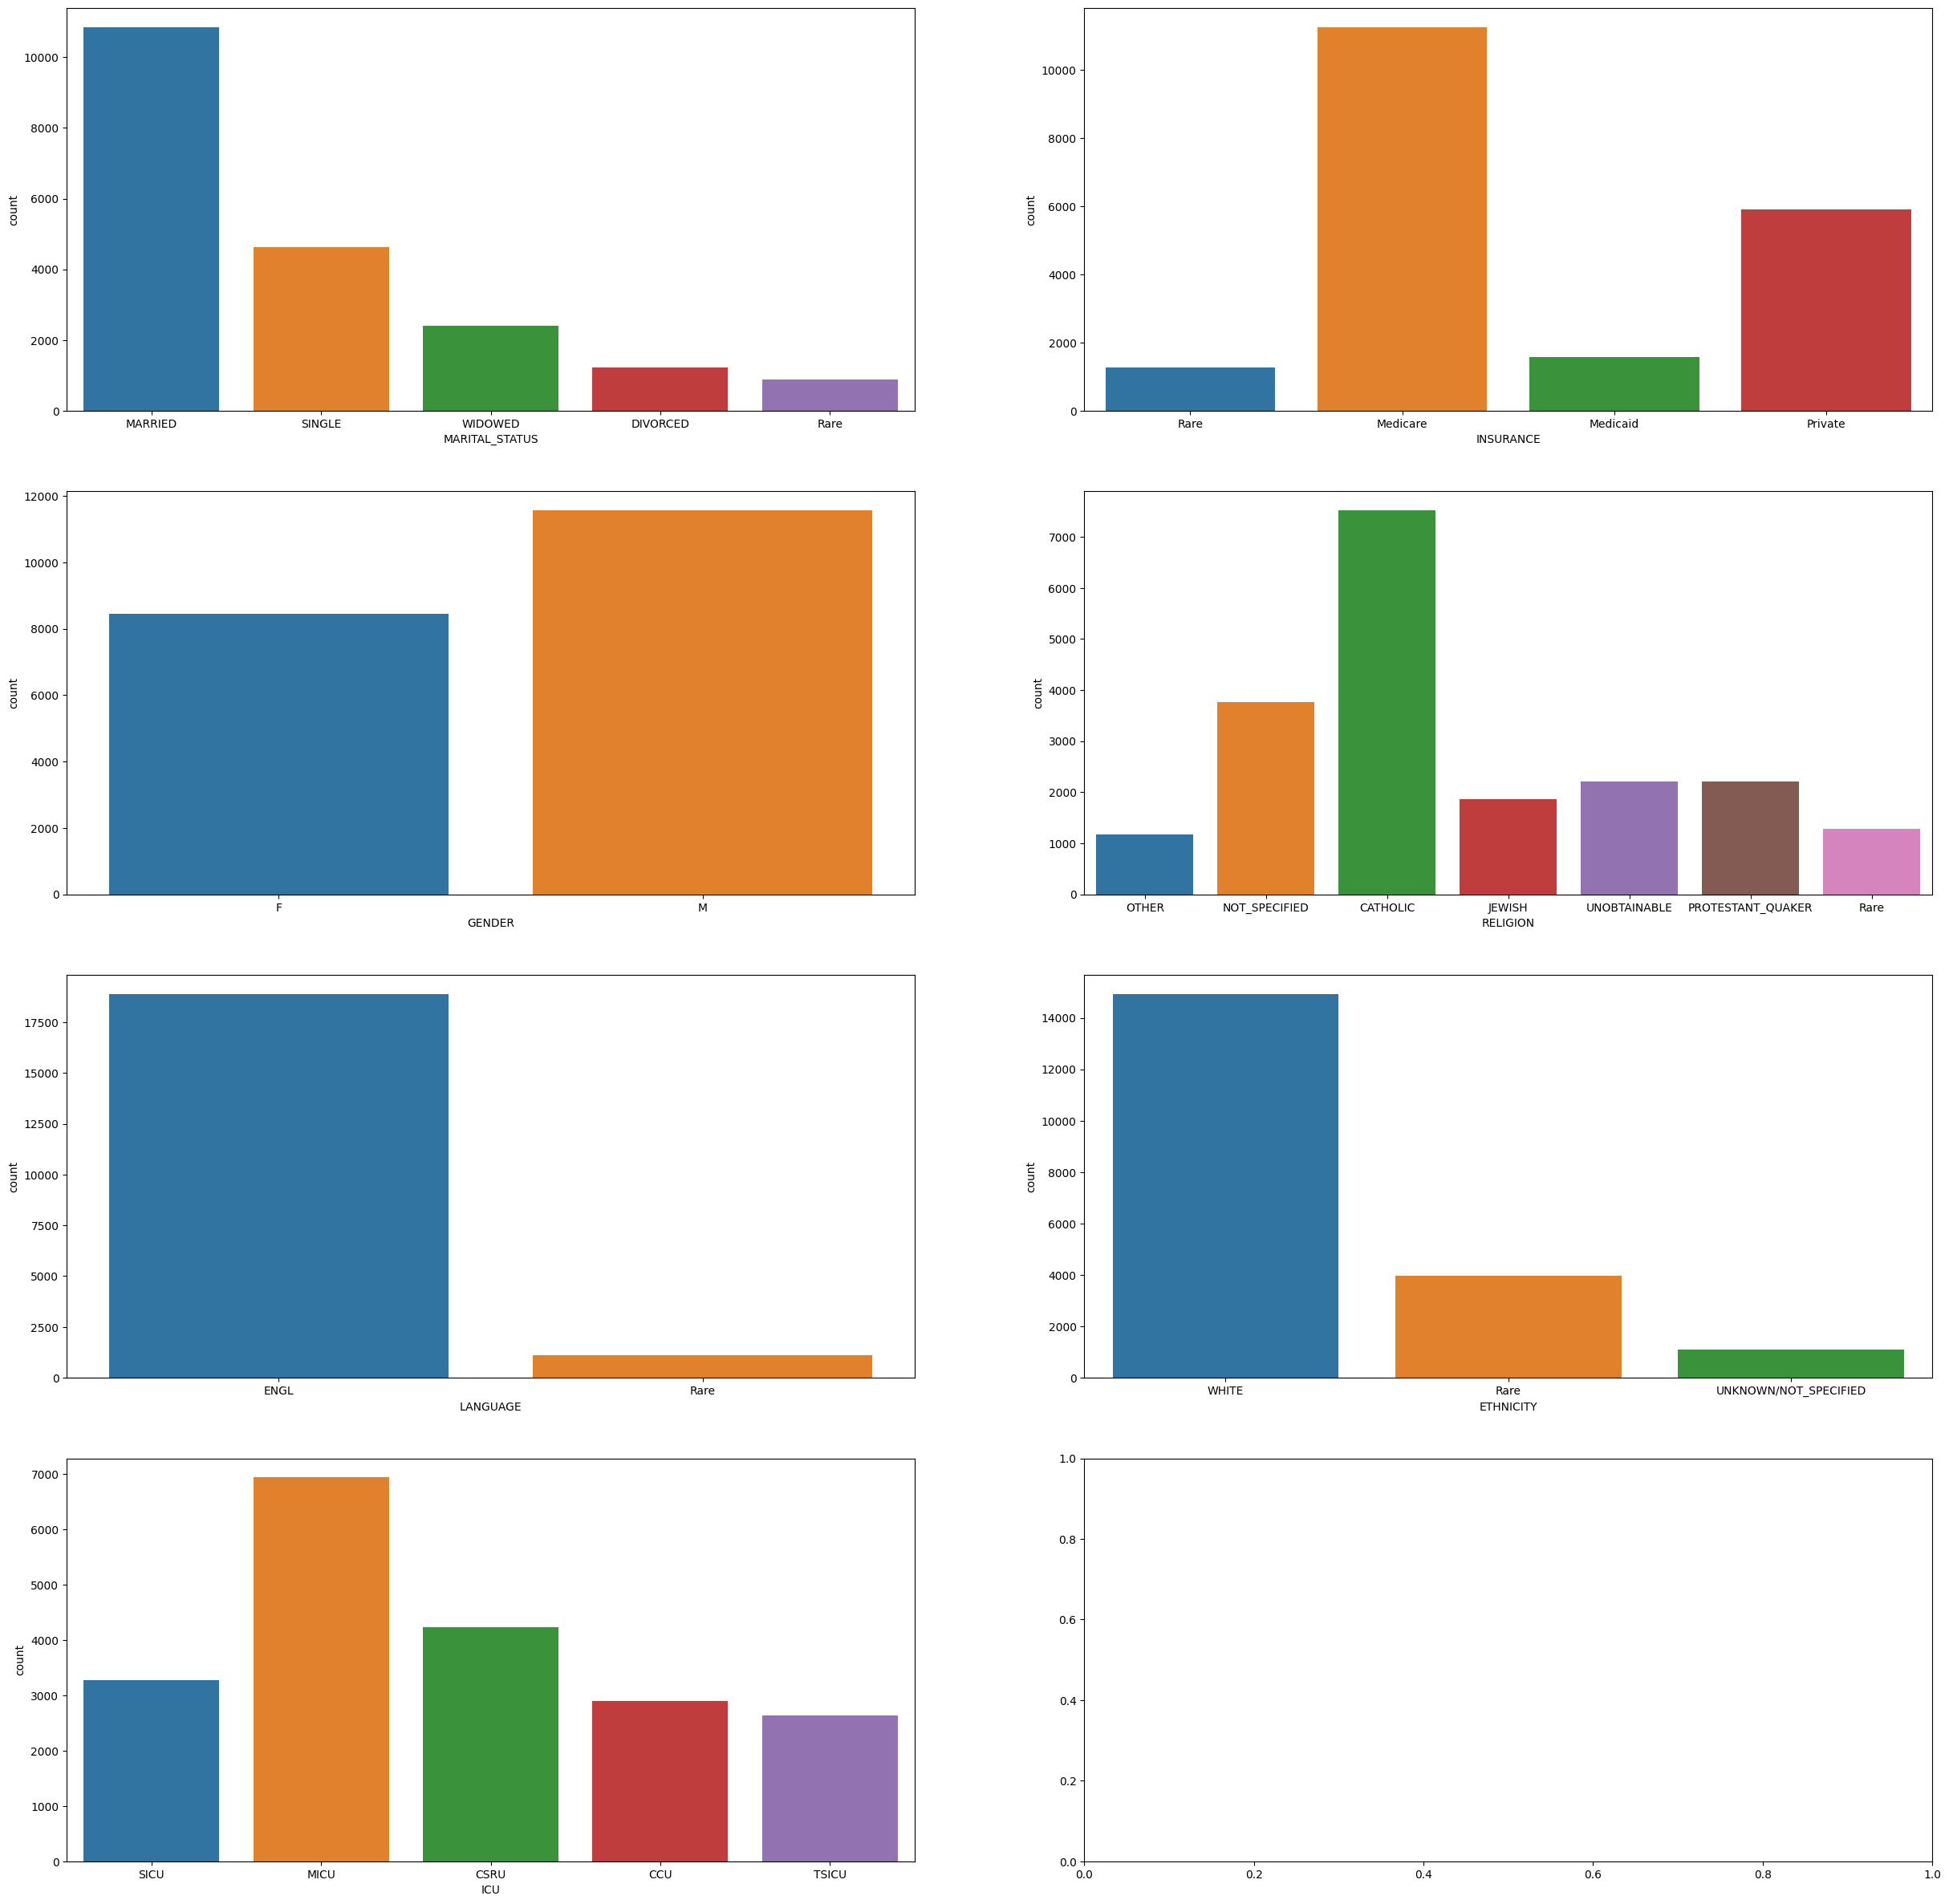

In [26]:
# bar charts of categorical features after reducing the scarcity
fig, axes = plt.subplots(4,2, figsize=(30,30))
sns.countplot(ax=axes[0,0],x=x_test_df["MARITAL_STATUS"])
sns.countplot(ax=axes[0,1],x=x_test_df["INSURANCE"])
sns.countplot(ax=axes[1,0],x=x_test_df["GENDER"])
sns.countplot(ax=axes[1,1],x=x_test_df["RELIGION"])
sns.countplot(ax=axes[2,0],x=x_test_df["LANGUAGE"])
sns.countplot(ax=axes[2,1],x=x_test_df["ETHNICITY"])
sns.countplot(ax=axes[3,0],x=x_test_df["ICU"])

### Transforming categorical data into integers using two types of encoding

Categorical variables are presented in the form of character strings. Most models will not be able to handle them in such a format.

#### Simple digital encoding

Two of the simplest methods are `LabelEncoder` from Scikit-Learn and` factorize` from pandas. They simply consist of replacing each new category encountered with an integer, starting with 0. This is perhaps not the most efficient method, since it presupposes proximity between the categories coded with close values.

#### 1-Hot encoding

Another type of encoding is often more efficient, in particular, it has the advantage of not ordering the classes in a particular way (not necessarily in line with the proximity of these classes to each other).

A pandas method allows this to be done in 1 line of code with the `get_dummies` function.

Exemple d'encodage 1-hot avec la fonction `get_dummies` de pandas (pour MARITAL_STATUS) :

|    |   DIVORCED |   LIFE_PARTNER |   MARRIED |   SEPARATED |   SINGLE |   UNKNOWN_(DEFAULT) |   WIDOWED |
|---:|-----------:|---------------:|----------:|------------:|---------:|--------------------:|----------:|
|  0 |          1 |              0 |         0 |           0 |        0 |                   0 |         0 |
|  1 |          0 |              0 |         0 |           0 |        1 |                   0 |         0 |
|  2 |          0 |              0 |         0 |           0 |        0 |                   0 |         1 |
|  3 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |
|  4 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |

You can choose your preferred way of encoding the categorical data.

<span style="color:red">Implement your solution below</span>

In [19]:
# using 1-Hot encoding
x_df = pd.get_dummies(x_df,columns=["INSURANCE","LANGUAGE","RELIGION","MARITAL_STATUS","ETHNICITY","GENDER","ICU"])
x_test_df = pd.get_dummies(x_test_df,columns=["INSURANCE","LANGUAGE","RELIGION","MARITAL_STATUS","ETHNICITY","GENDER","ICU"])

In [20]:
x_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79999 entries, 0 to 79998
Columns: 358 entries, AGE to ICU_TSICU
dtypes: float64(51), int64(279), uint8(28)
memory usage: 204.2 MB


In [21]:
x_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20001 entries, 0 to 20000
Columns: 358 entries, AGE to ICU_TSICU
dtypes: float64(51), int64(279), uint8(28)
memory usage: 51.0 MB


#### Removing single-valued variables (constants)

<span style="color:red">Implement your solution below</span>

In [22]:
# looking for variables with a unique value
x_df.nunique().sort_values()

Otconganom                1
Prevc-sectn               1
Neoplsmunsp               1
Fetaldistrs               1
Amniosdx                  1
                      ...  
GLUCOSE_MAX_DAY1      79546
RESP_RATE_MIN_DAY1    79552
RESP_RATE_MAX_DAY1    79563
RESP_RATE_MIN_DAY2    79576
GLUCOSE_MEAN_DAY1     79630
Length: 358, dtype: int64

In [36]:
x_test_df.nunique().sort_values()

Otconganom                1
Otcomplbir                1
Nmlpreg/del               1
Otinflskin                1
Otrespirca                1
                      ...  
RESP_RATE_MIN_DAY2    19975
RESP_RATE_MAX_DAY2    19976
GLUCOSE_MIN_DAY2      19981
GLUCOSE_MEAN_DAY1     19983
RESP_RATE_MIN_DAY1    19983
Length: 358, dtype: int64

In [23]:
# getting their index
unique_count = x_df.nunique()
to_del = [i for i,v in enumerate(unique_count) if v == 1]

In [ ]:
# not doing it for the test set since it would result in a loss of feature that wasn't constant when we trained
# unique_count_test = x_test_df.nunique()
# to_del_test = [i for i,v in enumerate(unique_count_test) if v == 1]

In [32]:
x_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79999 entries, 0 to 79998
Columns: 185 entries, AGE to ICU_TSICU
dtypes: float64(51), int64(106), uint8(28)
memory usage: 98.6 MB


In [33]:
x_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20001 entries, 0 to 20000
Columns: 185 entries, AGE to ICU_TSICU
dtypes: float64(51), int64(106), uint8(28)
memory usage: 24.6 MB


In [24]:
# removing them
x_df.drop(columns=x_df.columns[to_del], inplace=True)

# also from the test set since we don't learn from these features anymore
x_test_df.drop(columns=x_test_df.columns[to_del], inplace=True)

In [ ]:
# not deleting the constants of the test set
# x_test_df.drop(columns=x_test_df.columns[to_del_test], inplace=True)

In [25]:
# checking there is no more variables with a unique value
x_df.nunique().sort_values()

Skininfectn                                2
ECodes:Adverseeffectsofmedicalcare         2
ECodes:Adverseeffectsofmedicaldrugs        2
ECodes:Placeofoccurrence                   2
Prostatecan                                2
                                       ...  
GLUCOSE_MAX_DAY1                       79546
RESP_RATE_MIN_DAY1                     79552
RESP_RATE_MAX_DAY1                     79563
RESP_RATE_MIN_DAY2                     79576
GLUCOSE_MEAN_DAY1                      79630
Length: 185, dtype: int64

In [26]:
# there is still constants variables but they weren't in the training set which is way bigger so more likely representative
x_test_df.nunique().sort_values()

Osteoarthros              1
Othereyedx                1
Otjointdx                 1
Glaucoma                  1
Retinaldx                 1
                      ...  
RESP_RATE_MIN_DAY2    19975
RESP_RATE_MAX_DAY2    19976
GLUCOSE_MIN_DAY2      19981
GLUCOSE_MEAN_DAY1     19983
RESP_RATE_MIN_DAY1    19983
Length: 185, dtype: int64

### Creation of the validation set

<span style="color:red">Implement your solution below</span>

In [48]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    x_df, ys, test_size=0.2
)

### Size reduction via PCA

Test the PCA to reduce the number of dimensions and see if this improves the result.

Before applying the PCA, it is advisable to standardize the data.

<span style="color:red">Implement your solution below</span>

In [29]:
scaler = preprocessing.StandardScaler()

std_x_df = pd.DataFrame(scaler.fit_transform(x_df), columns=x_df.columns)
std_x_test_df = pd.DataFrame(scaler.fit_transform(x_test_df), columns=x_test_df.columns)

In [36]:
ys = scaler.fit_transform(ys.reshape(-1, 1))

AttributeError: 'Series' object has no attribute 'reshape'

Print a graph that represents the first 2 dimensions of PCA and comment briefly.

<span style="color:red">Implement your solution below</span>

<span style="color:red">
    Use markdown cells to add comments
</span>

## 5. Classification models

Train the model

### Baseline

`LogisticRegression` or `RandomForestClassifier`

In [18]:
SCORINGS = "balanced_accuracy"

In [19]:
model = ensemble.RandomForestClassifier(n_estimators=10)

# TODO: Try other models

model.fit(x_train, y_train)  # training

RandomForestClassifier(n_estimators=10)

<span style="color:red">Implement your solution below</span>

## 6. Evaluations

In [20]:
y_pred = model.predict(x_valid)  # predictions

score = metrics.balanced_accuracy_score(y_valid, y_pred)  # scoring

print(f"Balanced accuracy score: {score:.3g}")

Balanced accuracy score: 0.5


### Code: Cross-validation

Use cross-validation (to get a more reliable estimate) combined with an exploration of hyperparameters (to improve results).

You can change the value of the cross-validation number (CV) depending on the error value and the time to train the models (compromise).

In [21]:
CV = 10
SCORING = "balanced_accuracy"

<span style="color:red">Implement your solution below</span>

* **For 2 of the models** (at least 1 other than the proposed baseline):

    * For different values of one of the hyperparameters, give the average `balanced_accuracy` of the cross-validation in the form of Boxplots (or bar graph with an error bar): see the example presented in the graph below.
    
    * Briefly explain what observations to draw concerning the stability of the predictions.

![](img/boxplot-cv.png)

<span style="color:red">Implement your solution below</span>

* **For each of these 2 models, from the validation data created previously** (`x_valid`,` y_valid`):

    * Measure the area under the ROC curve (AUC) using the Scikit-Learn (`roc_auc_score`) function and compare the models with their respective combination of hyperparameters giving the best result.

<span style="color:red">Implement your solution below</span>

* **For the model and its combination of hyperparameters offering the best result**:

    * Present the confusion matrix and describe it succinctly.

<span style="color:red">
    Use markdown cells to add comments
</span>

### Code: Try to improve your score

* Data augmentation (optional)

Given the imbalance between the classes to predict (survive, died), we can hope to improve the score by rebalancing them. A typical approach is through data generation. One of the generation methods is [SMOTE](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE). For instance, it is implemented in the `imblearn` library.

`imblearn` was developed to fit the `sklearn` API.
In particular, it offers a version of the `pipeline` which allows integration with `sklearn`.

<span style="color:red">Implement your solution below</span>

### Explanation of what you have achieved, conclusion and perspectives

Start by giving your best result obtained during your submissions

Explain the path that led you there

* What you tried:
    * What worked
    * What didn't work and how you fixed it
* What method did you use to choose the hyperparameters?
* Compare the training time of the main models you used?

What would you have done if you had had more time?

<span style="color:red">Write your answer below</span>

## 7. Save the model predictions

* Use the following code to make predictions and to save them as a ZIP file
* Submit this ZIP file to [the challenge site](https://codalab.lisn.upsaclay.fr/competitions/328#participate-submit_results)
(`Participate > Submit/View Results > Submit`)
* The number of submissions is **limited** to **3 per day** and **30 in total!**
* Try your best to be the ***first on the leaderboard!***

<span style="color:red">
    !! Do not forget to modify the command of the prediction according to the data and models chosen !!
</span>

E.g.:

* Data: `x_test_df` or `x_baseline_test_df`

* Model : `model` or `search` (e.g., for `GridSearchCV`)

In [22]:
predictions = model.predict(x_baseline_test_df)  # compute predictions

PRED_PATH.mkdir(parents=True, exist_ok=True)

t_stamp = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
submission_fp = PRED_PATH / f"submission_{t_stamp}.zip"

pred_fname = "mimic_synthetic_test.csv"
compr_opts = dict(method="zip", archive_name=pred_fname)

pd.Series(predictions).to_csv(
    submission_fp, compression=compr_opts, index=False, header=False
)

print(f"The submission is ready: {submission_fp}")

The submission is ready: Submissions/submission_2022-11-23T21-53-58.zip


---

# Note on the dataset

The dataset does not contain actual medical data. It is not allowed to share these **confidential data** from ICU patients. To avoid this problem, the data have been replaced with **artificial data**.

To have credible data, they were generated using a generative adversarial network (**GAN**) Wasserstein.

For more information: <br/>
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, et al. [Privacy Preserving Synthetic Health Data](https://hal.inria.fr/hal-02160496/document). ESANN 2019 - European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, Apr 2019, Bruges, Belgium.

---